# Pandas怎么处理日期索引的缺失？


问题：按日期统计的数据，缺失了某天，导致数据不全该怎么补充日期？

公众号：蚂蚁学Python

可以用两种方法实现：  
1、DataFrame.reindex，调整dataframe的索引以适应新的索引  
2、DataFrame.resample，可以对时间序列重采样，支持补充缺失值

## 问题：如果缺失了索引该怎么填充？

In [2]:
import pandas as pd
%matplotlib inline

In [31]:
df = pd.DataFrame({
    "pdate": ["2019-12-01", "2019-12-02", "2019-12-04", "2019-12-05"],
    "pv": [100, 200, 400, 500],
    "uv": [10, 20, 40, 50],
})

df

,pdate,pv,uv
0,2019-12-01,100,10
1,2019-12-02,200,20
2,2019-12-04,400,40
3,2019-12-05,500,50


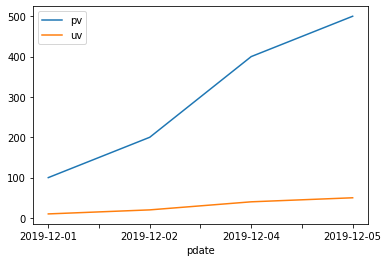

In [64]:
df.set_index("pdate").plot()

In [65]:
add_col = pd.DataFrame({'pdate':["2019-12-03"],"pv":[300],'uv':[30]})
add_col

,pdate,pv,uv
0,2019-12-03,300,30


In [66]:
df1 = pd.concat([df,add_col],axis=0,ignore_index=True)
df1

,pdate,pv,uv
0,2019-12-01,100,10
1,2019-12-02,200,20
2,2019-12-04,400,40
3,2019-12-05,500,50
4,2019-12-03,300,30


In [69]:
df1['pdate'] = pd.to_datetime(df1['pdate'])
df1.dtypes

pdate    datetime64[ns]
pv                int64
uv                int64
dtype: object

In [73]:
df1.sort_values(by='pdate',inplace=True)
df1.set_index(keys='pdate',inplace=True)
df1

,pv,uv
pdate,,
2019-12-01,100,10
2019-12-02,200,20
2019-12-03,300,30
2019-12-04,400,40
2019-12-05,500,50


***问题，这里缺失了2019-12-03的数据，导致数据不全该怎么补充？***

## 方法1：使用pandas.reindex方法

### 1、将df的索引变成日期索引

In [4]:
df_date = df.set_index("pdate")
df_date

,pv,uv
pdate,,
2019-12-01,100,10
2019-12-02,200,20
2019-12-04,400,40
2019-12-05,500,50


In [5]:
df_date.index

Index(['2019-12-01', '2019-12-02', '2019-12-04', '2019-12-05'], dtype='object', name='pdate')

In [6]:
# 将df的索引设置为日期索引
df_date = df_date.set_index(pd.to_datetime(df_date.index))
df_date

,pv,uv
pdate,,
2019-12-01,100,10
2019-12-02,200,20
2019-12-04,400,40
2019-12-05,500,50


In [7]:
df_date.index

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-04', '2019-12-05'], dtype='datetime64[ns]', name='pdate', freq=None)

### 2、使用pandas.reindex填充缺失的索引

In [8]:
# 生成完整的日期序列
pdates = pd.date_range(start="2019-12-01", end="2019-12-05")
pdates

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05'],
              dtype='datetime64[ns]', freq='D')

In [9]:
df_date_new = df_date.reindex(pdates, fill_value=0)
df_date_new

,pv,uv
2019-12-01,100,10
2019-12-02,200,20
2019-12-03,0,0
2019-12-04,400,40
2019-12-05,500,50


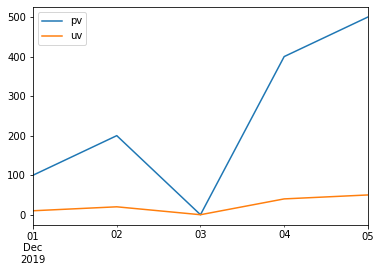

In [10]:
df_date_new.plot()

## 方法2：使用pandas.resample方法

### 1、先将索引变成日期索引

In [11]:
df

,pdate,pv,uv
0,2019-12-01,100,10
1,2019-12-02,200,20
2,2019-12-04,400,40
3,2019-12-05,500,50


In [12]:
df_new2 = df.set_index(pd.to_datetime(df["pdate"])).drop("pdate", axis=1)
df_new2

,pv,uv
pdate,,
2019-12-01,100,10
2019-12-02,200,20
2019-12-04,400,40
2019-12-05,500,50


In [13]:
df_new2.index

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-04', '2019-12-05'], dtype='datetime64[ns]', name='pdate', freq=None)

### 2、使用dataframe的resample的方法按照天重采样

resample的含义：  
改变数据的时间频率，比如把天数据变成月份，或者把小时数据变成分钟级别

resample的语法：    
(DataFrame or Series).resample(arguments).(aggregate function)

resample的采样规则参数：  
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [14]:
# 由于采样会让区间变成一个值，所以需要指定mean等采样值的设定方法
df_new2 = df_new2.resample("D").mean().fillna(0)
df_new2

,pv,uv
pdate,,
2019-12-01,100.0,10.0
2019-12-02,200.0,20.0
2019-12-03,0.0,0.0
2019-12-04,400.0,40.0
2019-12-05,500.0,50.0


In [15]:
# resample的使用方式
df_new2.resample("2D").mean()

,pv,uv
pdate,,
2019-12-01,150.0,15.0
2019-12-03,200.0,20.0
2019-12-05,500.0,50.0
